# 소규모 데이터셋으로 심층신경망 학습하기 3탄

# 미세 조정 (Fine-tuning)
1) 미세 조정이란?  
- 이전 편에서 수행했던 특성 추출 모델을 조금 더 우리의 데이터에 맞게 보완하는 과정  
- 특성 추출 모델에서 동결했던 상위 몇 개의 층을 해제하여 새로 추가한 FC 레이어와 함께 훈련시키는 방법  
- 사전 학습된 모델의 일부를 조정하기 때문에 미세 조정이라고 불림  

![fine_tuning](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)
#### 미세 조정 단계  
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가한다.  
2. 기반 네트워크를 동결한다.  
3. 새로 추가한 네트워크를 훈련한다.  
4. 기반 네트워크에서 일부 층의 동결을 해제한다.  
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련한다.  

- 처음 세 단계는 특성 추출을 할 때 완료  
- 네 번째 단계인 conv_base의 동결을 해제하고 개별 층을 동결

## 2) VGG 16 구조 확인 
```python
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```
- weights : 초기화할 가중치 값  
('None' : 랜덤 초기화 / 'imagenet' : imagenet으로 사전 훈련된 가중치 / path : 가중치값을 포함한 파일)  
- incldue_top : 최상위 완전 연결 레이어(Fully Connected Layer; FC) 포함/비포함 여부 (default=True)  
- input_shape : 입력 사이즈

In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3))

In [3]:
# 기반층 구조 재확인
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

마지막 3개의 합성곱 층(block5_conv1 ~ conv3)을 미세 조정한다.  
block_4까지는 그대로 두고 그 후의 block5_con1 ~ conv3는 학습의 대상이 된다. 

In [4]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [7]:
# 모델 훈련
import os
import os.path as osp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

base_dir = '/Transfer Learning/datasets_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20, 
    class_mode='binary')

validation_genertor = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_genertor,
    validation_steps=50)

/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-19 14:11:05.637527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-19 14:11:05.637701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-12-19 14:11:06.049993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.4821 - acc: 0.7750

2022-12-19 14:11:17.550588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 16s 145ms/step - loss: 0.4821 - acc: 0.7750 - val_loss: 0.3014 - val_acc: 0.8710
Epoch 2/30
100/100 [==============================] - 14s 141ms/step - loss: 0.3029 - acc: 0.8665 - val_loss: 0.2392 - val_acc: 0.9010
Epoch 3/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2437 - acc: 0.9010 - val_loss: 0.2024 - val_acc: 0.9120
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2081 - acc: 0.9145 - val_loss: 0.2114 - val_acc: 0.9130
Epoch 5/30
100/100 [==============================] - 14s 141ms/step - loss: 0.1776 - acc: 0.9310 - val_loss: 0.1851 - val_acc: 0.9290
Epoch 6/30
100/100 [==============================] - 14s 142ms/step - loss: 0.1607 - acc: 0.9345 - val_loss: 0.2194 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 14s 142ms/step - loss: 0.1517 - acc: 0.9440 - val_loss: 0.1832 - val_acc: 0.9260
Epoch 8/30
100/100 [==============================] - 14s 142ms/st

In [9]:
model.save('./cats_and_dogs_small_4.h5')

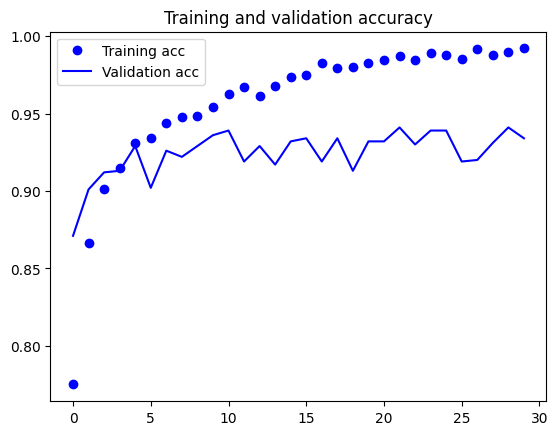

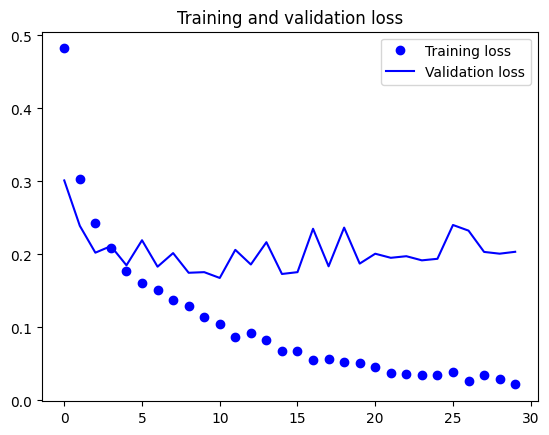

In [10]:
# 시각화
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 해석
- 검증 정확도가 확실히 1% 이상 향상  
- 학습을 시작한 이후에 바로 과대적합됨

# 3. 테스트 데이터로 평가

In [11]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9320000410079956


# 결과
- 94%의 정확도를 얻음  